In [5]:
# clone repository to access files
!git clone https://github.com/hella-innoLab/3PM_notebook.git

Cloning into '3PM_notebook'...
remote: Enumerating objects: 4238, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4238 (delta 13), reused 35 (delta 7), pack-reused 4191
Receiving objects: 100% (4238/4238), 82.83 MiB | 8.62 MiB/s, done.
Resolving deltas: 100% (2910/2910), done.


# Goal: Calculate the irradiance or irradiance time series for certain points in a room for a complex facade using the three Phase Method

# Three-Phase Method
From David Geisler-Moroder: *BSDF generation and use in annual, matrix-based daylight simulations with Radiance*, [RADIANCE workshop 2019](https://www.radiance-online.org/community/workshops/2019-new-york-ny) and from [ThreePhaseMethod Tutorial](https://www.radiance-online.org/learning/tutorials/Tutorial-ThreePhaseMethod.pdf) of Andy McNeil

![blabla](Images/ThreePhaseMethodOverview.png) 

i = VTDs or\
I = VTDS

| Variable | Definition | Common file extensions | 
| -------- | -------- | -------- | 
| I   | matrix containing time series of illuminance or luminance result   | .dat, .ill |
| i   | point in time illuminance or luminance result | |
| V   | view matrix, relating outgoing directions on window to desired results at interior   | .vmx  |
| T   | transmission matrix, relating incident window directions to exiting directions (BSDF)   | .xml  |
| D   | daylight matrix, relating sky patches to incident directions on window   | .dmx  |
| s   | sky vector, assigning luminance values to patches representing sky directions   | .skv  |
| S   |  sky matrix, a collection of sky vectors | .smx  |

### Install and load necessary packages
`pyradiance`: https://github.com/hella-innoLab/pyradiance from https://github.com/LBNL-ETA/pyradiance contains python executable functions of the RADIANCE code collection

In [ ]:
pip install pyradiance

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os # provides functions for interacting with the operating system
import pyradiance as pr # python implementation of RADIANCE
import subprocess as sp # running shell commands
import pandas as pd # data analysis and manipulation tool
import matplotlib.pyplot as plt # library for creating static, animated, and interactive visualizations
import numpy as np # scientific computing
from pyradiance.anci import BINPATH # path to compiled .c RADIANCE programs
from pathlib import Path
import sys
sys.path.append('3PM_notebook')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Test Environment 

### One room building with surrounding ground

![test](Images/seminarraum_ground.png)

### Room
- one north-orientated window
- no interior

room floor plane in meter: 
\begin{equation}
\begin{pmatrix}
  x_1 & y_1 & z_1  \\
  x_2 & y_2 & z_2  \\
  x_3 & y_3 & z_3  \\
  x_4 & y_4 & z_4  \\
\end{pmatrix} =
\begin{pmatrix}
  0 & 0 & 0  \\
  10 & 0 & 0  \\
  10 & 6 & 0  \\
  0 & 6 & 0  \\
\end{pmatrix}
\end{equation}
<br />

<figure>
    <img src="Images/seminarraum.png"
         alt="Tutorial room">
    <figcaption>Fish eye RADIANCE picture (using rpict) of the room from view point (0.2, 0.2, 1.5) and view direction (1, 1, 0) for a randomly chosen sky.</figcaption>
</figure>

### Calculate the horizontal irradiance for given points in the room
The points are evently distibuted in the room and located at desk height (0.75 m):
- dx = 0.5 m
- dy = 0.5 m
- z = 0.5 m 
- x = 0.1 ... 9.9 m
- y = 0.1 ... 6.1 m

Each point is represneted by its location (x,y,z) and view direction (vx, vy, vz)

[Text(0.5, 0, 'x (m)'), Text(0.5, 0.5, 'y (m)'), Text(0.5, 0, 'height (m)')]

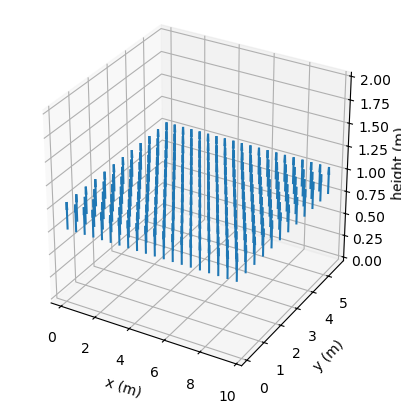

In [2]:
# Create sensor grid 0.75 above ground
files_path = os.path.join('3PM_notebook', 'files')
sensor_file_path = os.path.join(files_path,'pts','seminarraum.pts')
sender_file_path = Path(f"{files_path}/scene/seminarraum_vmx_glow.rad")

'''
create sensor path
'''
pts_z = 0.75
pts_x = np.arange(0.1, 9.9, 0.5)
pts_y = np.arange(0.1, 6.1, 0.5)
x, y = np.meshgrid(pts_x, pts_y)
pts = np.array([[x, y, pts_z, 0, 0, 1] for x in pts_x for y in pts_y])

np.savetxt(sensor_file_path, pts, fmt='%1.2f')

# plot of the points
x, y, z = pts[:,0], pts[:,1], pts[:,2]
vx, vy, vz = pts[:,3], pts[:,4], pts[:,5]

ax = plt.figure().add_subplot(projection='3d', aspect='equal')

ax.quiver(x, y, z, vx, vy, vz, length=0.3) #quiver length 0.3 m 
ax.set(zlim = [0,2])
ax.set(xlabel = "x (m)", ylabel = "y (m)", zlabel = "height (m)")

## View matrix

The view matrix characterizes the relationship between light leaving a window and arriving at a point.

![test](Images/3PM_VMX.png)

![test](Images/VMX_method.png)

In [3]:
# get number of available CPUs in the system
nprocs = os.cpu_count()

# calculate the view matrix from the window to a illuminance sensor
# sender: window with a glow acting as light source
sender_file_path = Path(f"{files_path}/scene/seminarraum_vmx_glow.rad")
# scene representing the room and its material
scene_file_path = Path(f"{files_path}/scene/seminarraum_scene.rad")
# vmx file the results are written into
vmx_file_path = Path(f"{files_path}/matrices/seminarraum.vmx")

rcopts = f"-V- -n {nprocs} -w- -I+ -ab 5 -ad 65536 -lw 1.0e-6 -faa"
cmd = f"{BINPATH}/rfluxmtx {rcopts} < {sensor_file_path} - {sender_file_path} {scene_file_path} > {vmx_file_path}"

os.system(cmd)

print(f"view matrix stored in {vmx_file_path}")

view matrix stored in /Users/marenhaid/Trainings/2019_RadianceWorkshop_David/3PM_notebook/files/matrices/seminarraum.vmx


## View matrix V results

For n points, the view matrix takes the dimensions

$$ V \in n x 145 $$

Thus, the contribution of individual patches to the irradiance at different points 

<figure class="image">
  <img src="Images/Klems_145_path.png" width="600" height="450">
  <figcaption>source: Ward, Gregory, et al. "Simulating the daylight performance of complex fenestration systems using bidirectional scattering distribution functions within radiance." Leukos 7.4 (2011): 241-261.</figcaption>
</figure>

E.g., comparison between a point in the back of the room and a point close to the window

1. p1 [5.1, 0.6, 0.75, 0, 0, 1]
2. p2 [5.1, 4.6, 0.75, 0, 0, 1]

Text(0.5, 1.0, 'Point 2: close to the window')

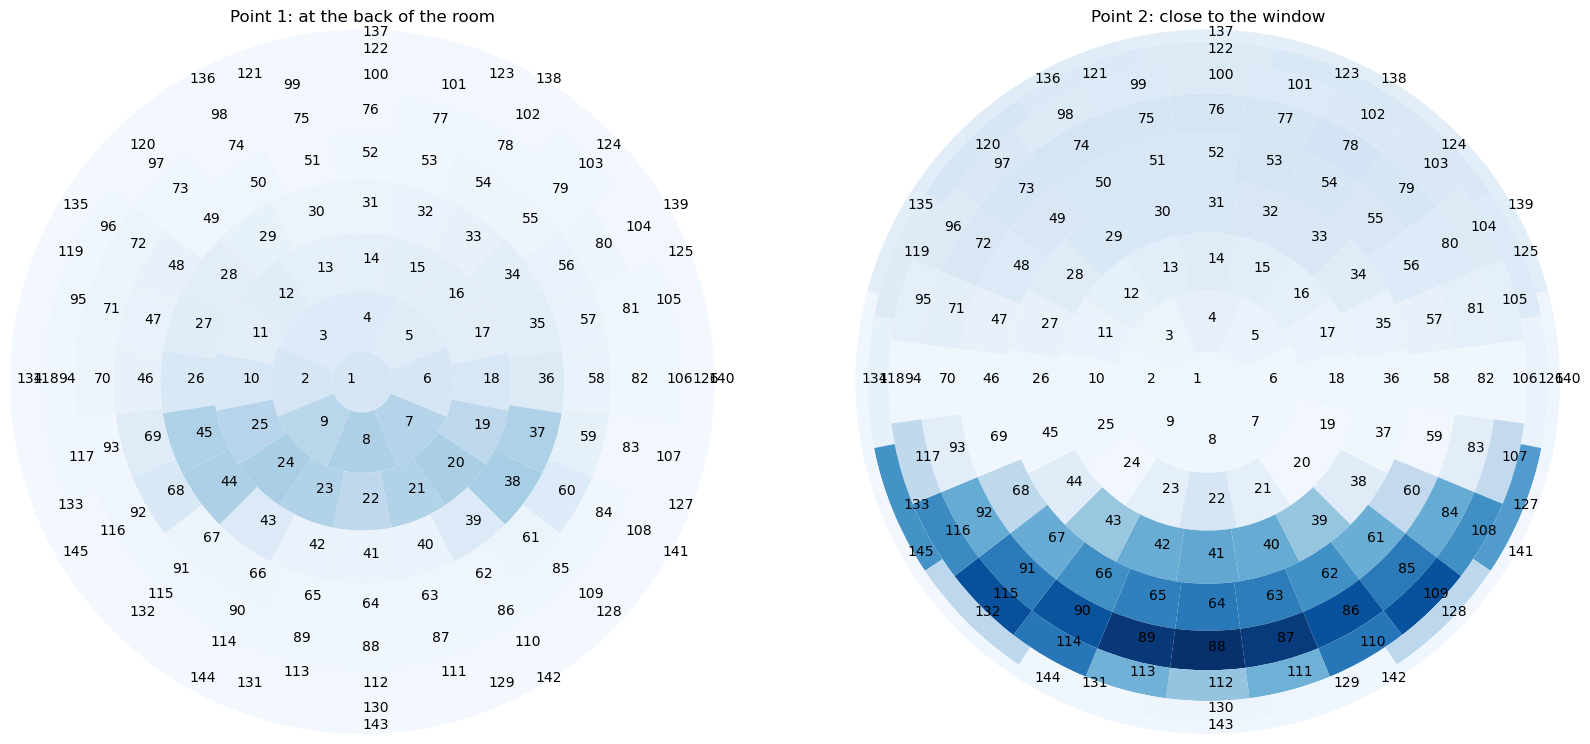

In [4]:
#import vmx
from plotKlemsDiscretization import plotKlemsDisc

# find points in 
ind_p1 = np.where((x == 5.1) & (y == 0.6))[0][0]
ind_p2 = np.where((x == 5.1) & (y == 4.6))[0][0]

# Load the data
header_n = 10
with open(vmx_file_path) as f:
    vmx_data = f.readlines()[header_n:]


data_p1 = np.array([float(v) for v in vmx_data[ind_p1].split()])
data_p2 = np.array([float(v) for v in vmx_data[ind_p2].split()])

data_p1_mat = np.reshape(data_p1, (145, 3))
data_p2_mat = np.reshape(data_p2, (145, 3))

data_p1_R = data_p1_mat[:,0]
data_p2_R = data_p2_mat[:,0]

c_max = np.max([np.max(data_p1_R), np.max(data_p2_R)])

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(121,aspect='equal')
plotKlemsDisc(data_p1_mat[:,0], ax1, norm=False, cmax=c_max)
ax1.set_title('Point 1: at the back of the room')

ax2 = fig.add_subplot(122,aspect='equal')
plotKlemsDisc(data_p2_mat[:,0], ax2, norm=False, cmax=c_max)
ax2.set_title('Point 2: close to the window')

## TASK: do the same analysis for a point close the window but on opposite sides of the room

1. p1 [0.6, 3.1, 0.75, 0, 0, 1]
2. p2 [9.1, 3.1, 0.75, 0, 0, 1]

In [26]:
# TODO

## BSDF

Bidirectional scattering distribution function 

Contains data for: 
![BSDF content](Images/bsdf_content.png)

For thre three phase method, the `Transmission Front` is requiered which represents the tranmission from the outdoors into the indoors. 

![test](Images/3PM_BSDF.png)

![test](Images/BSDF_method.png)


In [7]:
# pre calculated using genBSDF
bsdf_file_path = Path(f"{files_path}/BSDF/AR92S_20.xml")

## TASK: BSDF intepretation

Have a look into the BSDF data using the online [bsdf viewer of ladybug](https://www.ladybug.tools/bsdf-viewer/). Try to interpret the differences in the Visible Transmission Front for different patches in the incident hemisphere for a BSDF of an AR92S slat with 20 deg tilt (files/BSDF/AR92S_20.xml) . 

## Daylight matrix

The daylight matrix contains luminous flux transfer coefficients from the sky divisions to the window's incident Klems divisions.

![test](Images/3PM_DMX.png)

![test](Images/DMX_method.png)

In [8]:
sky_subdiv = 1

window_file_path = Path(f"{files_path}/scene/seminarraum_dmx_dummy.rad")
glow1_rein_file_path = Path(f"{files_path}/misc/sky_glow1_rein{sky_subdiv}.rad")
room_mat_file_path = Path(f"{files_path}/mat/seminarraum.mat")
room_file_path = Path(f"{files_path}/scene/seminarraum.rad")
dmx_file_path = Path(f"{files_path}/matrices/seminarraum.dmx")

rcopts = f"-V- -n {nprocs} -w- -ab 2 -ad 512 -lw 1.0e-6 -faa -c 1450" # low to show
cmd = f"{BINPATH}/rfluxmtx {rcopts} {window_file_path} {glow1_rein_file_path} {room_mat_file_path} {room_file_path} > {dmx_file_path}"

os.system(cmd)

print(f"daylight matrix stored in {dmx_file_path}")

daylight matrix stored in /Users/marenhaid/Trainings/2019_RadianceWorkshop_David/3PM_notebook/files/matrices/seminarraum.dmx


Text(0.5, 1.0, 'Ground patch')

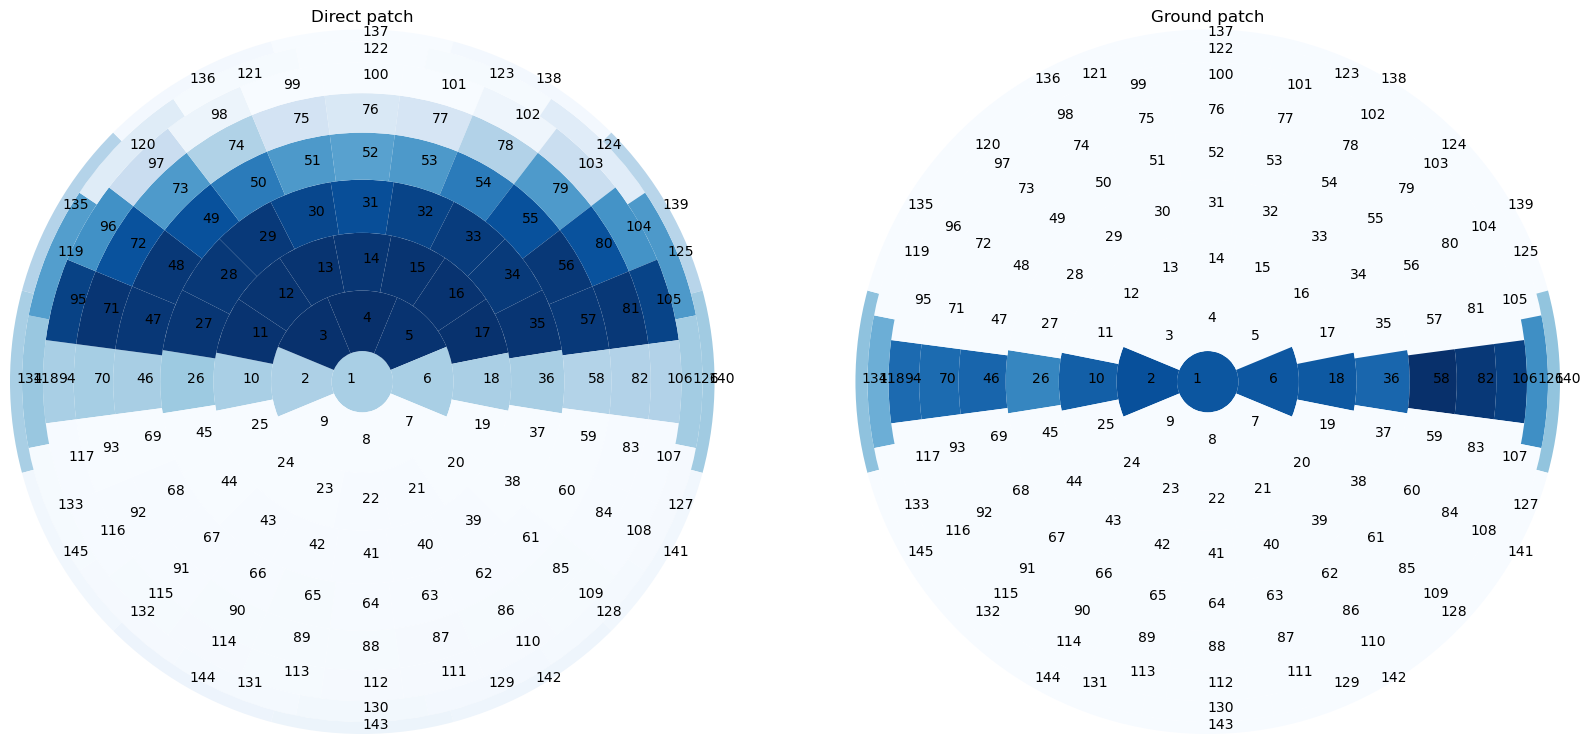

In [9]:
# plot daylight matrix 
with open(dmx_file_path) as f:
    data_dmx = f.readlines()[11:]
    
    
dmx_matrix = np.vstack([np.array([float(v) for v in d.split()]) for d in data_dmx])


front_data = dmx_matrix[:,118*3]
ground_data = dmx_matrix[:,0*3]

c_max = np.max([np.max(front_data), np.max(ground_data)])


fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(121,aspect='equal')
plotKlemsDisc(front_data, ax1, norm=False)
ax1.set_title('Direct patch')

ax2 = fig.add_subplot(122,aspect='equal')
plotKlemsDisc(ground_data, ax2, norm=False)
ax2.set_title('Ground patch')


## Sky distribution

![test](Images/3PM_SKY.png)

Here: time series

In [11]:
from epw2wea import epw2wea
epw_file_path = Path(f"{files_path}/weather/AUT_TR_Innsbruck.AP.111200_TMYx.epw")
wea_file_path = Path(f"{files_path}/weather/IBK_sky.wea")
wea_selection_file_path = Path(f"{files_path}/weather/IBK_sky_day01.wea")
smx_file_path = Path(f"{files_path}/weather/IBK_sky_day01.smx")

epw2wea(epw_file_path, wea_file_path)

# select only first day to show...
lines_n = 30
with open(wea_file_path, "r") as file_in , open(wea_selection_file_path, 'w') as file_out:
    for i in range(lines_n):
        line = next(file_in)
        file_out.write(line)
        
#gendaymtx - generate an annual Perez sky matrix from a weather tape
cmd = f"{BINPATH}/gendaymtx -m {sky_subdiv} {wea_selection_file_path} > {smx_file_path}"

os.system(cmd)

print(f"sky matrix stored in {smx_file_path}")

sky matrix stored in /Users/marenhaid/Trainings/2019_RadianceWorkshop_David/3PM_notebook/files/weather/IBK_sky_day01.smx


/Users/marenhaid/anaconda3/envs/daylight_class/lib/python3.11/site-packages/pyradiance/bin/gendaymtx: warning - unusually bright at 11.5 on 1-1
/Users/marenhaid/anaconda3/envs/daylight_class/lib/python3.11/site-packages/pyradiance/bin/gendaymtx: warning - unusually bright at 12.5 on 1-1
/Users/marenhaid/anaconda3/envs/daylight_class/lib/python3.11/site-packages/pyradiance/bin/gendaymtx: warning - unusually bright at 13.5 on 1-1
/Users/marenhaid/anaconda3/envs/daylight_class/lib/python3.11/site-packages/pyradiance/bin/gendaymtx: warning - unusually bright at 14.5 on 1-1
/Users/marenhaid/anaconda3/envs/daylight_class/lib/python3.11/site-packages/pyradiance/bin/gendaymtx: warning - unusually bright at 15.5 on 1-1


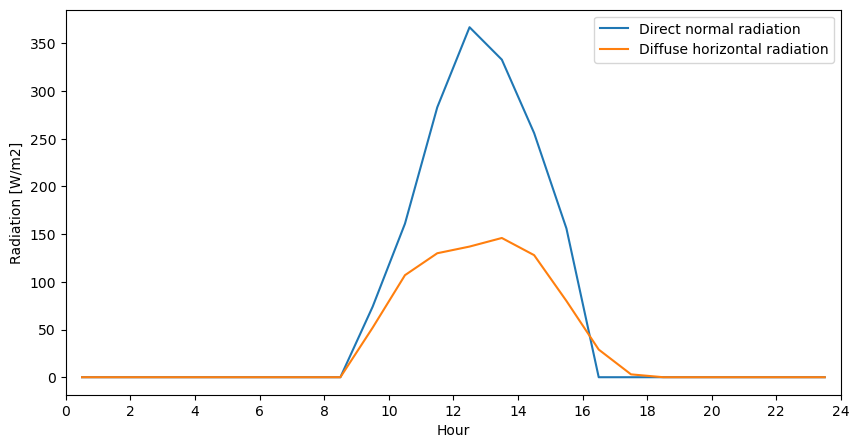

In [12]:
# Plot weater data: direct normal radiation and diffuse horizontal radiation

with open(wea_selection_file_path) as f:
    wea_data = f.readlines()[6:]

wea_matrix = np.vstack([np.array([float(v) for v in d.split()]) for d in wea_data])

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)

ax.plot(wea_matrix[:,2], wea_matrix[:,3], label='Direct normal radiation')
ax.plot(wea_matrix[:,2], wea_matrix[:,4], label='Diffuse horizontal radiation')
ax.set_xlabel('Hour')
ax.set(xlim = [0,24], xticks = np.arange(0,25,2))
ax.set_ylabel('Radiation [W/m2]')
ax.legend()


## Results

![test](Images/3PM_result.png)


In [14]:
result_file_path = Path(f"{files_path}/result/seminarraum.dat")

# I= VTDS = (.vmx)*(.bsdf)*(.dmx)*(.smx)
cmd = f"{BINPATH}/dctimestep {vmx_file_path} {bsdf_file_path} {dmx_file_path} {smx_file_path} > {result_file_path}"

os.system(cmd)

# calculate illuminance for sensors
ill_file_path = Path(f"{files_path}/result/seminarraum.ill")

cmd = f"{BINPATH}/rmtxop -fa -c 47.448 119.951 11.601 -t {result_file_path} > {ill_file_path}"

os.system(cmd)

print(f"results strored in {ill_file_path}")


results strored in /Users/marenhaid/Trainings/2019_RadianceWorkshop_David/3PM_notebook/files/result/seminarraum.ill


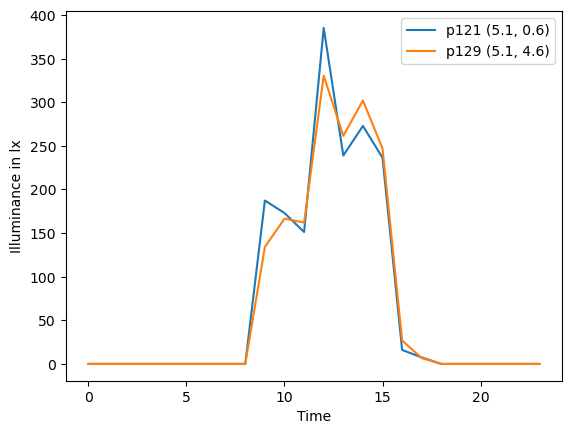

In [15]:
# plot illuminance time series for two points in the room
header_n = 12
with open(ill_file_path) as f:
    data = f.readlines()[header_n:]

data_matrix = np.vstack([np.array([float(v) for v in d.split()]) for d in data])

x, y = np.meshgrid(pts_x, pts_y)
# plot time series of illuminance at point 44 and 30 (used before)
ind_p1 = np.where((pts[:,0] == 5.1) & (pts[:,1] == 0.6))[0][0]
ind_p2 = np.where((pts[:,0] == 5.1) & (pts[:,1] == 4.6))[0][0]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(data_matrix[:,ind_p1], label=f'p{ind_p1} (5.1, 0.6)')
ax.plot(data_matrix[:,ind_p2], label=f'p{ind_p2} (5.1, 4.6)')
ax.set(xlabel='Time', ylabel='Illuminance in lx')
ax.legend()




Text(0, 0.5, 'Illuminance in lx')

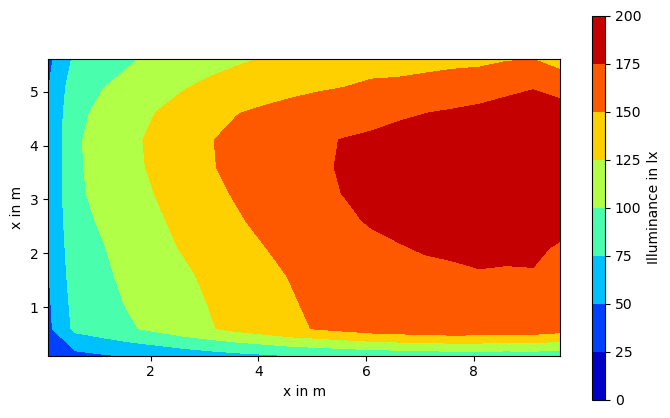

In [16]:
# plot illuminance distribution in at noon 
x_n = pts_x.size
y_n = pts_y.size
data_noon = data_matrix[11,:].reshape(x_n,y_n)


fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8], aspect='equal')
cax = fig.add_axes([0.95,0.1,0.02,0.8])
cplot = ax.contourf(pts_x,pts_y,data_noon.T, cmap='jet')
ax.set(xlabel='x in m', ylabel='x in m')
fig.colorbar(cplot, cax=cax)
cax.set_ylabel('Illuminance in lx')

## TASK: Plot illuminance distribution at 9 am and 3 pm and compare the results. Can you explain the differences?

In [25]:
# TODO

## TASK: 
- Why are the highest illuminance values not close to the window?
- Change the BSDF to ARS92_-1 and compare the results to the ones for ARS92_20

## TASK Do the same analysis for a south orientated seminar room
- room floor plane in meter: 
\begin{equation}
\begin{pmatrix}
  x_1 & y_1 & z_1  \\
  x_2 & y_2 & z_2  \\
  x_3 & y_3 & z_3  \\
  x_4 & y_4 & z_4  \\
\end{pmatrix} =
\begin{pmatrix}
  0 & 0 & 0  \\
  -10 & 0 & 0  \\
  -10 & -6 & 0  \\
  0 & -6 & 0  \\
\end{pmatrix}
\end{equation}
<br />
### Files to change
PTS
- Positions of sensors have to be adapted to new room dimensions
VMX
- `sender_file_path = Path(f"{files_path}/scene/seminarraum_vmx_glow_south.rad")`
- `scene_file_path = Path(f"{files_path}/scene/seminarraum_scene_south.rad")`

DMX
- `window_file_path = Path(f"{files_path}/scene/seminarraum_dmx_dummy_south.rad")`
- `room_file_path = Path(f"{files_path}/scene/seminarraum_south.rad")`